In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import daft 


..............AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


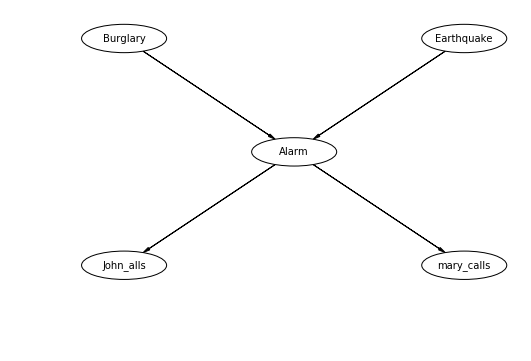

In [2]:
pgm = daft.PGM([9,6],origin=[1, 0.5])

pgm.add_node(daft.Node('B','Burglary',3,6,aspect=3))
pgm.add_node(daft.Node('E','Earthquake',9,6,aspect=3))

pgm.add_node(daft.Node('A','Alarm',6,4,aspect=3))

pgm.add_node(daft.Node('J','John_alls',3,2,aspect=3))

pgm.add_node(daft.Node('M','mary_calls',9,2,aspect=3))

pgm.add_edge('B','A')

pgm.add_edge('E','A')

pgm.add_edge('A','J')




pgm.add_edge('A','M')   

pgm.render();



1.	Graph must be acyclic
2.	Node "Alarm" has two parent "burglary" and "earthquake" and alarm has two descentant john and mary given the condition above the node "john" and "mary" will be independent of the node "burglary" and "earthquake"
3.	"john" amd "mary" will entirely dependent on the node "Alarm"
4.	as we have 5 node in the graph we need 2 Pow 5 entries to stores entire ditribution table.
5.	but we can represent the the joint distribution entries in 10 as the values are depending to the Nodes

6.  Joint probabailty for the above network is as follows:
    p(B,E,A,J,M)= p(B)*p(A)*p(A|B,E)*p(J|A)*p(J|M)


In [3]:
model = pm.Model();
with model:

    burglary = pm.Bernoulli('burglary',.001)

    earthquake = pm.Bernoulli('earthquake',.002)

    alarm_prop = pm.Deterministic('alarm_prop',pm.math.switch(burglary,pm.math.switch(earthquake,0.95,0.94),pm.math.switch(earthquake,.29,.001)))

    alarm =pm.Bernoulli('alarm',alarm_prop)

    john_prop = pm.Deterministic('john_prop',pm.math.switch(alarm,.90,.05))

    john = pm.Bernoulli('john',john_prop)

    mary_prop = pm.Deterministic('mary_prop',pm.math.switch(alarm,.70,.01))

    mary = pm.Bernoulli('mary',mary_prop)

   #step= pm.BinaryGibbsMetropolis([burglary,earthquake,alarm,john,mary])

    trace =pm.sample(100000,tune=50000, progressbar = True)

    
    
    

Assigned BinaryGibbsMetropolis to burglary
Assigned BinaryGibbsMetropolis to earthquake
Assigned BinaryGibbsMetropolis to alarm
Assigned BinaryGibbsMetropolis to john
Assigned BinaryGibbsMetropolis to mary
100%|████████████████████████████████| 150000/150000 [01:10<00:00, 2129.70it/s]


we used bernoulli distribution above as we know that either Node is ON or OFF.

# Why sampling is important in probabilistic model
Sampling is important in probabilistic model because of following reasons 
1.	To calculate the Normalize constant which is the integral of likelihood and prior
2.	To calculate all the possible values that posterior can take using the integral which is very hard to do by hand when our model have lots of Nodes.
3.	Markove chain sampling we use sum rule to calculate the next Node probability based on the prevoius Node and we can do that for n number of Node while using sampling which is almost impossible by hand.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D8DF7B8>,
      dtype=object)

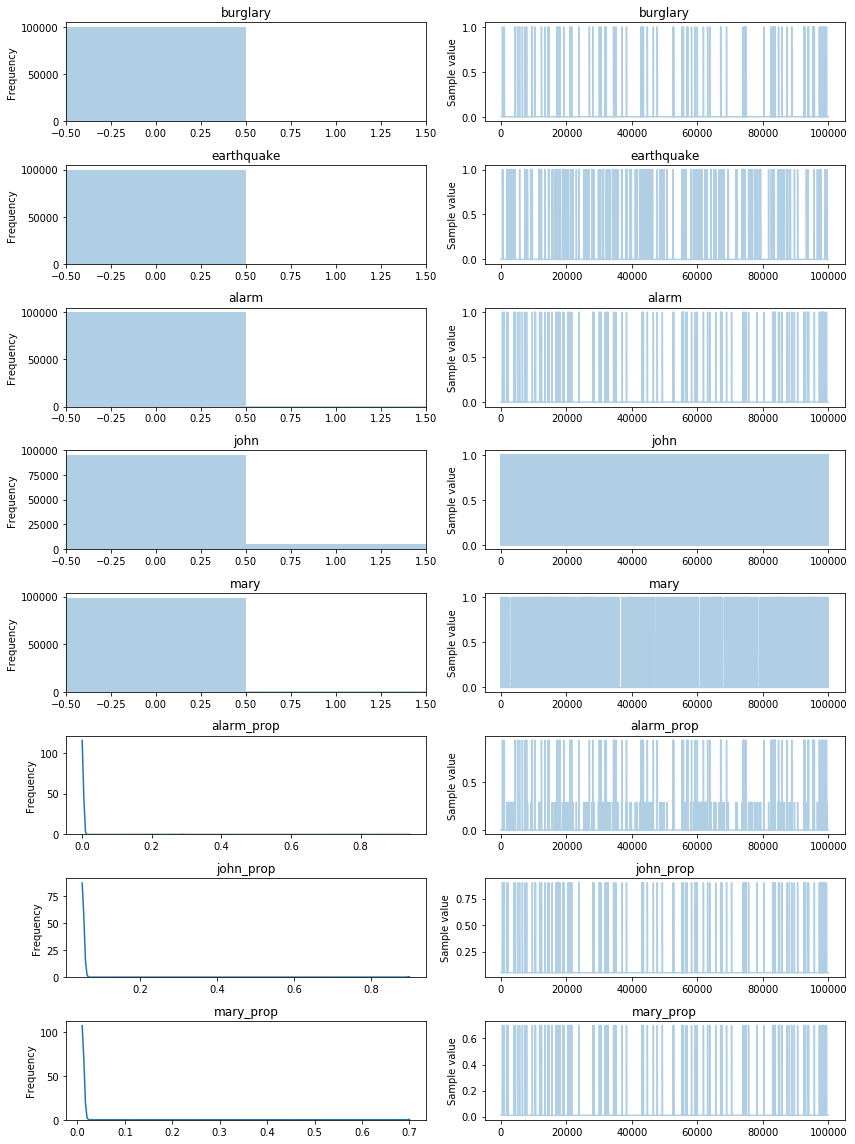

In [4]:
pm.traceplot(trace)

In [32]:
dictionary = {'burglary': [1 if ii else 0 for ii in trace['burglary'].tolist()],
              'earthquake':   [1 if ii else 0 for ii in trace['earthquake'].tolist()],
              'alarm': [1 if ii else 0 for ii in trace['alarm'].tolist()],
              'john': [1 if ii else 0 for ii in trace['john'].tolist()],
              'mary': [1 if ii else 0 for ii in trace['mary'].tolist()],
    
}

In [33]:
df = pd.DataFrame(dictionary)

probabilty alarm buzzing because of burglary

In [34]:
prop_Alarm_Burglary =float(df[(df['burglary']==1)& (df['alarm']==1)].shape[0])/df[df['alarm']==1].shape[0]
print(prop_Alarm_Burglary)


0.33992094861660077


Probabilty alarm buzzing because of eartquake

In [35]:
prop_Alarm_Earthquake =float(df[(df['earthquake']==1)& (df['alarm']==1)].shape[0])/df[df['alarm']==1].shape[0]
print(prop_Alarm_Earthquake)


0.24110671936758893


Propbabilty that both john and mary calls that alarm is buzzing but there is no eartquake and burglary

In [36]:
prop_Alarm_johncalls_marycalls_noburglary_noearthquake =float(df[(df['earthquake']==0)& (df['burglary']==0)& (df['john']==1) & (df['mary']==1) & (df['alarm']==1)].shape[0])/df[(df['john']==1)&  (df['mary']==1)].shape[0]
print(prop_Alarm_johncalls_marycalls_noburglary_noearthquake)


0.33653846153846156


# Inference
Any inference operation of the form P(values of some node | values of the other node) can be computed: Probability that both John and Mary call given that there was a burglar


In [37]:
prop_johncalls_marycalls_burglar =float(df[(df['mary']==1)& (df['john']==1)& (df['burglary']==1)].shape[0])/df[(df['burglary']==1)].shape[0]
print(prop_johncalls_marycalls_burglar)


0.5257731958762887


In [38]:
prop_j_a =float(df[(df['john']==1)&  (df['alarm']==1)].shape[0])/df[df['alarm']==1].shape[0]
print(prop_j_a)

0.8735177865612648


In [39]:
prop_m_a =float(df[(df['mary']==1)&  (df['alarm']==1)].shape[0])/df[df['alarm']==1].shape[0]
print(prop_m_a)

0.7075098814229249
